In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
train_data_gen = image_generator.flow_from_directory(directory='Data',target_size=(128,128),
                                                     subset='training')
val_data_gen = image_generator.flow_from_directory(directory='Data',target_size=(128,128),
                                                   subset='validation')

Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.


In [17]:
#train_path = "output/train"
#test_path = "output/val"
#IMAGE_SIZE = [224,224]

In [22]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [19]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [213]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))


# SqueezeNet

In [83]:
bnmomemtum = 0.9


def fire_module(x, squeeze, expand):
    y = Conv2D(filters=squeeze, kernel_size=1, activation="relu", padding="same")(x)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y1 = Conv2D(filters=expand // 2, kernel_size=1, activation="relu", padding="same")(y)
    y1 = BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = Conv2D(filters=expand // 2, kernel_size=3, activation="relu", padding="same")(y)
    y3 = BatchNormalization(momentum=bnmomemtum)(y3)
    return concatenate([y1, y3])

In [84]:
def SqueezeNet(input_shape, num_classes):
    input = Input(shape=input_shape)
    y = Conv2D(kernel_size=7, filters=96, strides=2, padding="same", activation="relu")(input)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 32, 128)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 32, 128)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 64, 256)
    y = MaxPooling2D(pool_size=2)(y)
    y = fire_module(y, 64, 256)
    y = Conv2D(kernel_size=1, filters=1000, strides=1, padding="same", activation="relu")(y)
    y = GlobalAveragePooling2D()(y)
    y = Dense(num_classes, activation="softmax")(y)
    model = Model(input, y)
    return model

In [85]:
model = SqueezeNet(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), num_classes=4
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 112, 112, 96) 14208       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 112, 112, 96) 384         conv2d_52[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 55, 55, 96)   0           batch_normalization_50[0][0]     
____________________________________________________________________________________________

In [7]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

In [8]:
EPOCHS = 200
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [87]:
history = model.fit(
    train_set,
    epochs=EPOCHS,
    validation_data=test_set,
    callbacks=[learning_rate_reduction, early_stop],
)

Epoch 1/200
24/24 [==============================] - 110s 4s/step - loss: 1.2861 - accuracy: 0.4054 - f1_m: 0.2011 - precision_m: 0.5740 - recall_m: 0.1315 - val_loss: 2.6556 - val_accuracy: 0.2404 - val_f1_m: 0.2374 - val_precision_m: 0.2386 - val_recall_m: 0.2362
Epoch 2/200
24/24 [==============================] - 86s 4s/step - loss: 0.9537 - accuracy: 0.6201 - f1_m: 0.5323 - precision_m: 0.7029 - recall_m: 0.4359 - val_loss: 53.4658 - val_accuracy: 0.2568 - val_f1_m: 0.2550 - val_precision_m: 0.2550 - val_recall_m: 0.2550
Epoch 3/200
24/24 [==============================] - 109s 5s/step - loss: 0.5260 - accuracy: 0.8067 - f1_m: 0.7794 - precision_m: 0.8241 - recall_m: 0.7413 - val_loss: 44.7177 - val_accuracy: 0.2568 - val_f1_m: 0.2550 - val_precision_m: 0.2550 - val_recall_m: 0.2550
Epoch 4/200
24/24 [==============================] - 98s 4s/step - loss: 0.4295 - accuracy: 0.8389 - f1_m: 0.8434 - precision_m: 0.8592 - recall_m: 0.8287 - val_loss: 209.2416 - val_accuracy: 0.2568 - 

In [247]:
model.save('squeeze.h5')

In [184]:
squee_acc = history.history["val_accuracy"][19]
squee_prec = history.history["val_precision_m"][19]
squee_rec = history.history["val_recall_m"][19]
squee_f1 = history.history["val_f1_m"][19]

In [217]:
storeResults('SqueezeNet',squee_acc,squee_prec,squee_rec,squee_f1)

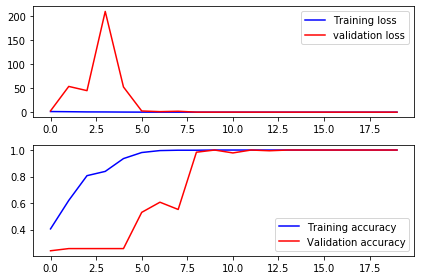

In [88]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history["loss"], color="b", label="Training loss")
ax1.plot(history.history["val_loss"], color="r", label="validation loss")
ax1.legend()

ax2.plot(history.history["accuracy"], color="b", label="Training accuracy")
ax2.plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc="best")
plt.tight_layout()
plt.show()

# AlexNet

In [89]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

In [90]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(128,128,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(4))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0

In [91]:
AlexNet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])

In [92]:
history1 = AlexNet.fit(
    train_set,
    epochs=EPOCHS,
    validation_data=test_set,
    callbacks=[learning_rate_reduction, early_stop],
    steps_per_epoch = 24,
    validation_steps = 24
)

Epoch 1/200
24/24 [==============================] - 182s 7s/step - loss: 0.9949 - accuracy: 0.6319 - f1_m: 0.5325 - precision_m: 0.7161 - recall_m: 0.4341 - val_loss: 195.7722 - val_accuracy: 0.2514 - val_f1_m: 0.2508 - val_precision_m: 0.2508 - val_recall_m: 0.2508
Epoch 2/200
24/24 [==============================] - 160s 7s/step - loss: 0.5012 - accuracy: 0.8966 - f1_m: 0.8420 - precision_m: 0.9592 - recall_m: 0.7525 - val_loss: 23.4345 - val_accuracy: 0.2582 - val_f1_m: 0.2614 - val_precision_m: 0.2614 - val_recall_m: 0.2614
Epoch 3/200
24/24 [==============================] - 161s 7s/step - loss: 0.3745 - accuracy: 0.9613 - f1_m: 0.9457 - precision_m: 0.9858 - recall_m: 0.9100 - val_loss: 4.7531 - val_accuracy: 0.2609 - val_f1_m: 0.2589 - val_precision_m: 0.2589 - val_recall_m: 0.2589
Epoch 4/200
24/24 [==============================] - 161s 7s/step - loss: 0.3133 - accuracy: 0.9840 - f1_m: 0.9750 - precision_m: 0.9898 - recall_m: 0.9612 - val_loss: 2.4395 - val_accuracy: 0.2623 -

In [248]:
AlexNet.save('alexnet.h5')

In [186]:
alex_acc = history1.history["val_accuracy"][30]
alex_prec = history1.history["val_precision_m"][30]
alex_rec = history1.history["val_recall_m"][30]
alex_f1 = history1.history["val_f1_m"][30]

In [218]:
storeResults('AlexNet',alex_acc,alex_prec,alex_rec,alex_f1)

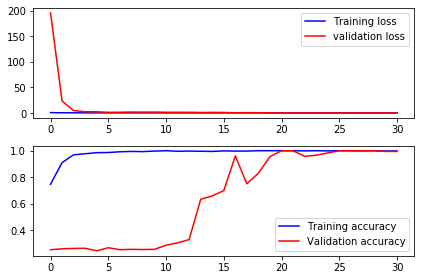

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history1.history["loss"], color="b", label="Training loss")
ax1.plot(history1.history["val_loss"], color="r", label="validation loss")
ax1.legend()

ax2.plot(history1.history["accuracy"], color="b", label="Training accuracy")
ax2.plot(history1.history["val_accuracy"], color="r", label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc="best")
plt.tight_layout()
plt.show()

# CNN

In [94]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

In [95]:
np.random.seed(1000)  # Fix seed

models = Sequential()

models.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(227, 227, 3), activation='relu'))
models.add(BatchNormalization(axis=3))
models.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
models.add(MaxPooling2D((2, 2)))
models.add(BatchNormalization(axis=3))
models.add(Dropout(0.1))

models.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
models.add(BatchNormalization(axis=3))
models.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
models.add(MaxPooling2D((2, 2)))
models.add(BatchNormalization(axis=3))
models.add(Dropout(0.1))

models.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
models.add(BatchNormalization(axis=3))
models.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
models.add(MaxPooling2D((2, 2)))
models.add(BatchNormalization(axis=3))
models.add(Dropout(0.1))

#Fully Connected Layer
models.add(Dense(4096))
models.add(BatchNormalization())
models.add(Activation('relu'))
#Add Dropout
models.add(Dropout(0.4))

#Fully Connected Layer
models.add(Dense(1000))
models.add(BatchNormalization())
models.add(Activation('relu'))
#Add Dropout
models.add(Dropout(0.4))

#Depth Concebntration Connected Layer
models.add(Dense(4096))
models.add(BatchNormalization())
models.add(Activation('relu'))
#Add Dropout
models.add(Dropout(0.4))

#Depth Concebntration Connected Layer
models.add(Dense(1000))
models.add(BatchNormalization())
models.add(Activation('relu'))
#Add Dropout
models.add(Dropout(0.4))

models.add(Flatten())

models.add(Dense(256, activation='relu'))
models.add(BatchNormalization())
models.add(Dropout(0.5))

models.add(Dense(256, activation='relu'))
models.add(BatchNormalization())
models.add(Dropout(0.5))

models.add(Dense(4, activation='softmax'))

models.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 223, 223, 64)      4864      
_________________________________________________________________
batch_normalization_13 (Batc (None, 223, 223, 64)      256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 219, 219, 64)      102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 109, 109, 64)      0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 105, 105, 128)    

In [96]:
models.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [97]:
history2 = models.fit(
    train_set,
    epochs=EPOCHS,
    validation_data=test_set,
    callbacks=[learning_rate_reduction, early_stop],
    steps_per_epoch = 24,
    validation_steps = 24
)

Epoch 1/200
24/24 [==============================] - 1946s 81s/step - loss: 1.9655 - accuracy: 0.3493 - f1_m: 0.3010 - precision_m: 0.3450 - recall_m: 0.2679 - val_loss: 7359.5439 - val_accuracy: 0.2514 - val_f1_m: 0.2503 - val_precision_m: 0.2503 - val_recall_m: 0.2503
Epoch 2/200
24/24 [==============================] - 1909s 80s/step - loss: 1.1855 - accuracy: 0.5484 - f1_m: 0.5255 - precision_m: 0.5802 - recall_m: 0.4812 - val_loss: 982.6042 - val_accuracy: 0.2514 - val_f1_m: 0.2523 - val_precision_m: 0.2523 - val_recall_m: 0.2523
Epoch 3/200
24/24 [==============================] - 1431s 59s/step - loss: 1.0896 - accuracy: 0.5956 - f1_m: 0.5730 - precision_m: 0.6123 - recall_m: 0.5391 - val_loss: 204.4859 - val_accuracy: 0.2527 - val_f1_m: 0.2557 - val_precision_m: 0.2557 - val_recall_m: 0.2557
Epoch 4/200
24/24 [==============================] - 1888s 79s/step - loss: 0.8993 - accuracy: 0.6815 - f1_m: 0.6581 - precision_m: 0.7076 - recall_m: 0.6158 - val_loss: 109.2498 - val_accu

Epoch 31/200
24/24 [==============================] - 1890s 79s/step - loss: 0.0148 - accuracy: 0.9960 - f1_m: 0.9956 - precision_m: 0.9956 - recall_m: 0.9956 - val_loss: 0.9035 - val_accuracy: 0.6981 - val_f1_m: 0.7010 - val_precision_m: 0.7030 - val_recall_m: 0.6990
Epoch 32/200
24/24 [==============================] - 1927s 81s/step - loss: 0.0164 - accuracy: 0.9985 - f1_m: 0.9985 - precision_m: 0.9985 - recall_m: 0.9985 - val_loss: 0.0499 - val_accuracy: 0.9822 - val_f1_m: 0.9795 - val_precision_m: 0.9815 - val_recall_m: 0.9776

Epoch 00032: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 33/200
24/24 [==============================] - 1888s 79s/step - loss: 0.0113 - accuracy: 0.9965 - f1_m: 0.9958 - precision_m: 0.9965 - recall_m: 0.9951 - val_loss: 0.0301 - val_accuracy: 0.9877 - val_f1_m: 0.9883 - val_precision_m: 0.9883 - val_recall_m: 0.9883
Epoch 34/200
24/24 [==============================] - 1891s 79s/step - loss: 0.0088 - accuracy: 0.9994 - f1_m: 0

In [249]:
models.save('cnn.h5')

In [188]:
cnn_acc = history2.history["val_accuracy"][13]
cnn_prec = history2.history["val_precision_m"][13]
cnn_rec = history2.history["val_recall_m"][13]
cnn_f1 = history2.history["val_f1_m"][13]

In [219]:
storeResults('CNN',cnn_acc,cnn_prec,cnn_rec,cnn_f1)

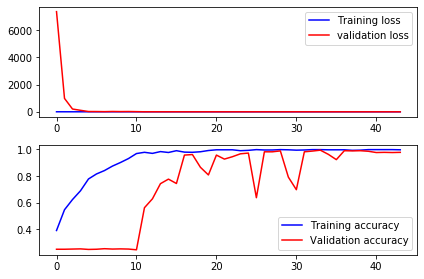

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history2.history["loss"], color="b", label="Training loss")
ax1.plot(history2.history["val_loss"], color="r", label="validation loss")
ax1.legend()

ax2.plot(history2.history["accuracy"], color="b", label="Training accuracy")
ax2.plot(history2.history["val_accuracy"], color="r", label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [99]:
from sklearn.metrics import confusion_matrix
y_p=models.predict(val_data_gen,verbose=1,steps=len(val_data_gen))
y_pr=np.argmax(y_p,axis=1)
cm1=confusion_matrix(val_data_gen.classes,y_pr)

6/6 [==============================] - 103s 16s/step


# Xception

In [20]:
from keras.applications.xception import Xception
from keras.layers import Activation, Dense,GlobalAveragePooling2D, Dropout
from keras.models import Model

In [25]:
base_model = Xception(weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model2 = Model(inputs=base_model.input, outputs=predictions)

model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [27]:
history3 = model2.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=train_data_gen,
    callbacks=[learning_rate_reduction, early_stop],
    steps_per_epoch = 24,
    validation_steps = 24
)

Epoch 1/200
24/24 [==============================] - 28s 1s/step - loss: 0.0201 - accuracy: 0.9933 - f1_m: 0.9902 - precision_m: 0.9902 - recall_m: 0.9902 - val_loss: 0.3053 - val_accuracy: 0.9604 - val_f1_m: 0.9612 - val_precision_m: 0.9612 - val_recall_m: 0.9612
Epoch 2/200
24/24 [==============================] - 27s 1s/step - loss: 0.0075 - accuracy: 1.0000 - f1_m: 0.9993 - precision_m: 1.0000 - recall_m: 0.9987 - val_loss: 0.2442 - val_accuracy: 0.9686 - val_f1_m: 0.9685 - val_precision_m: 0.9685 - val_recall_m: 0.9685
Epoch 3/200
24/24 [==============================] - 27s 1s/step - loss: 0.0038 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.2193 - val_accuracy: 0.9672 - val_f1_m: 0.9672 - val_precision_m: 0.9672 - val_recall_m: 0.9672
Epoch 4/200
24/24 [==============================] - 27s 1s/step - loss: 0.0051 - accuracy: 0.9973 - f1_m: 0.9956 - precision_m: 0.9987 - recall_m: 0.9928 - val_loss: 0.2426 - val_accuracy: 0.9658 - val_f1

In [28]:
model2.save('xec.h5')

In [190]:
xec_acc = history3.history["val_accuracy"][40]
xec_prec = history3.history["val_precision_m"][40]
xec_rec = history3.history["val_recall_m"][40]
xec_f1 = history3.history["val_f1_m"][40]

In [220]:
storeResults('Xecption',xec_acc,xec_prec,xec_rec,xec_f1)

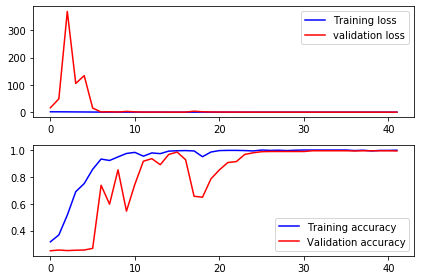

In [180]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history3.history["loss"], color="b", label="Training loss")
ax1.plot(history3.history["val_loss"], color="r", label="validation loss")
ax1.legend()

ax2.plot(history3.history["accuracy"], color="b", label="Training accuracy")
ax2.plot(history3.history["val_accuracy"], color="r", label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Feature EXtraction

In [29]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [31]:
# Read input images and assign labels based on folder names
print(os.listdir("output/"))

SIZE = 224  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

['train', 'val']


In [32]:
for directory_path in glob.glob("output/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

Abnormal
output/train\Abnormal\HB(1).jpg
output/train\Abnormal\HB(10).jpg
output/train\Abnormal\HB(100).jpg
output/train\Abnormal\HB(101).jpg
output/train\Abnormal\HB(102).jpg
output/train\Abnormal\HB(103).jpg
output/train\Abnormal\HB(104).jpg
output/train\Abnormal\HB(105).jpg
output/train\Abnormal\HB(106).jpg
output/train\Abnormal\HB(107).jpg
output/train\Abnormal\HB(108).jpg
output/train\Abnormal\HB(109).jpg
output/train\Abnormal\HB(110).jpg
output/train\Abnormal\HB(111).jpg
output/train\Abnormal\HB(112).jpg
output/train\Abnormal\HB(113).jpg
output/train\Abnormal\HB(114).jpg
output/train\Abnormal\HB(115).jpg
output/train\Abnormal\HB(116).jpg
output/train\Abnormal\HB(118).jpg
output/train\Abnormal\HB(119).jpg
output/train\Abnormal\HB(12).jpg
output/train\Abnormal\HB(120).jpg
output/train\Abnormal\HB(121).jpg
output/train\Abnormal\HB(122).jpg
output/train\Abnormal\HB(123).jpg
output/train\Abnormal\HB(125).jpg
output/train\Abnormal\HB(126).jpg
output/train\Abnormal\HB(128).jpg
output/tr

output/train\HMI\PMI(14).jpg
output/train\HMI\PMI(140).jpg
output/train\HMI\PMI(141).jpg
output/train\HMI\PMI(142).jpg
output/train\HMI\PMI(143).jpg
output/train\HMI\PMI(144).jpg
output/train\HMI\PMI(145).jpg
output/train\HMI\PMI(147).jpg
output/train\HMI\PMI(148).jpg
output/train\HMI\PMI(149).jpg
output/train\HMI\PMI(15).jpg
output/train\HMI\PMI(150).jpg
output/train\HMI\PMI(152).jpg
output/train\HMI\PMI(153).jpg
output/train\HMI\PMI(154).jpg
output/train\HMI\PMI(155).jpg
output/train\HMI\PMI(156).jpg
output/train\HMI\PMI(157).jpg
output/train\HMI\PMI(158).jpg
output/train\HMI\PMI(159).jpg
output/train\HMI\PMI(160).jpg
output/train\HMI\PMI(161).jpg
output/train\HMI\PMI(162).jpg
output/train\HMI\PMI(163).jpg
output/train\HMI\PMI(164).jpg
output/train\HMI\PMI(165).jpg
output/train\HMI\PMI(166).jpg
output/train\HMI\PMI(167).jpg
output/train\HMI\PMI(168).jpg
output/train\HMI\PMI(169).jpg
output/train\HMI\PMI(17).jpg
output/train\HMI\PMI(170).jpg
output/train\HMI\PMI(171).jpg
output/train\

output/train\MI\MI(64).jpg
output/train\MI\MI(65).jpg
output/train\MI\MI(66).jpg
output/train\MI\MI(67).jpg
output/train\MI\MI(69).jpg
output/train\MI\MI(7).jpg
output/train\MI\MI(70).jpg
output/train\MI\MI(71).jpg
output/train\MI\MI(72).jpg
output/train\MI\MI(73).jpg
output/train\MI\MI(74).jpg
output/train\MI\MI(75).jpg
output/train\MI\MI(76).jpg
output/train\MI\MI(77).jpg
output/train\MI\MI(78).jpg
output/train\MI\MI(79).jpg
output/train\MI\MI(8).jpg
output/train\MI\MI(80).jpg
output/train\MI\MI(81).jpg
output/train\MI\MI(82).jpg
output/train\MI\MI(83).jpg
output/train\MI\MI(84).jpg
output/train\MI\MI(85).jpg
output/train\MI\MI(86).jpg
output/train\MI\MI(87).jpg
output/train\MI\MI(88).jpg
output/train\MI\MI(89).jpg
output/train\MI\MI(9).jpg
output/train\MI\MI(90).jpg
output/train\MI\MI(91).jpg
output/train\MI\MI(92).jpg
output/train\MI\MI(93).jpg
output/train\MI\MI(94).jpg
output/train\MI\MI(95).jpg
output/train\MI\MI(96).jpg
output/train\MI\MI(98).jpg
output/train\MI\MI(99).jpg
Norm

output/train\Normal\Normal(46).jpg
output/train\Normal\Normal(47).jpg
output/train\Normal\Normal(48).jpg
output/train\Normal\Normal(49).jpg
output/train\Normal\Normal(5).jpg
output/train\Normal\Normal(50).jpg
output/train\Normal\Normal(51).jpg
output/train\Normal\Normal(54).jpg
output/train\Normal\Normal(57).jpg
output/train\Normal\Normal(58).jpg
output/train\Normal\Normal(59).jpg
output/train\Normal\Normal(6).jpg
output/train\Normal\Normal(60).jpg
output/train\Normal\Normal(61).jpg
output/train\Normal\Normal(62).jpg
output/train\Normal\Normal(63).jpg
output/train\Normal\Normal(64).jpg
output/train\Normal\Normal(65).jpg
output/train\Normal\Normal(66).jpg
output/train\Normal\Normal(67).jpg
output/train\Normal\Normal(68).jpg
output/train\Normal\Normal(69).jpg
output/train\Normal\Normal(7).jpg
output/train\Normal\Normal(70).jpg
output/train\Normal\Normal(71).jpg
output/train\Normal\Normal(72).jpg
output/train\Normal\Normal(73).jpg
output/train\Normal\Normal(74).jpg
output/train\Normal\Nor

In [33]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [34]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("output/train/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

In [35]:
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [36]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [111]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [112]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Xception Based Feature Extraction

In [121]:
base_model = Xception(weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model2 = Model(inputs=base_model.input, outputs=predictions)

model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [122]:
#Now, let us use features from convolutional network for RF
feature_extractor= model2.predict(x_train)

In [123]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_train_feature = features #This is our X input to RF

In [124]:
X_test_feature = model2.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# Random Forest

In [134]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

rf_acc_xec = accuracy_score(test_labels, prediction_RF)
rf_prec_xec = precision_score(test_labels, prediction_RF,average='weighted')
rf_rec_xec = recall_score(test_labels, prediction_RF,average='weighted')
rf_f1_xec = f1_score(test_labels, prediction_RF,average='weighted')

In [221]:
storeResults('Xecption - RF',rf_acc_xec,rf_prec_xec,rf_rec_xec,rf_f1_xec)

# SVM

In [136]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_svm = svm_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_svm = le.inverse_transform(prediction_svm)

svm_acc_xec = accuracy_score(test_labels, prediction_svm)
svm_prec_xec = precision_score(test_labels, prediction_svm,average='weighted')
svm_rec_xec = recall_score(test_labels, prediction_svm,average='weighted')
svm_f1_xec = f1_score(test_labels, prediction_svm,average='weighted')

In [222]:
storeResults('Xecption - SVM',svm_acc_xec,svm_prec_xec,svm_rec_xec,svm_f1_xec)

# KNN

In [137]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_knn = knn_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_knn = le.inverse_transform(prediction_knn)

knn_acc_xec = accuracy_score(test_labels, prediction_knn)
knn_prec_xec = precision_score(test_labels, prediction_knn,average='weighted')
knn_rec_xec = recall_score(test_labels, prediction_knn,average='weighted')
knn_f1_xec = f1_score(test_labels, prediction_knn,average='weighted')

In [223]:
storeResults('Xecption - KNN',knn_acc_xec,knn_prec_xec,knn_rec_xec,knn_f1_xec)

# Decision Tree

In [138]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=30)
dt_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_dt = dt_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_dt = le.inverse_transform(prediction_dt)

dt_acc_xec = accuracy_score(test_labels, prediction_dt)
dt_prec_xec = precision_score(test_labels, prediction_dt,average='weighted')
dt_rec_xec = recall_score(test_labels, prediction_dt,average='weighted')
dt_f1_xec = f1_score(test_labels, prediction_dt,average='weighted')

In [224]:
storeResults('Xecption - DT',dt_acc_xec,dt_prec_xec,dt_rec_xec,dt_f1_xec)

# Naive Bayes

In [139]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_nb = nb_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_nb = le.inverse_transform(prediction_nb)

nb_acc_xec = accuracy_score(test_labels, prediction_nb)
nb_prec_xec = precision_score(test_labels, prediction_nb,average='weighted')
nb_rec_xec = recall_score(test_labels, prediction_nb,average='weighted')
nb_f1_xec = f1_score(test_labels, prediction_nb,average='weighted')

In [225]:
storeResults('Xecption - NB',nb_acc_xec,nb_prec_xec,nb_rec_xec,nb_f1_xec)

# CNN Based Feature Extraction

In [140]:
np.random.seed(1000)  # Fix seed

models = Sequential()

models.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(227, 227, 3), activation='relu'))
models.add(BatchNormalization(axis=3))
models.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
models.add(MaxPooling2D((2, 2)))
models.add(BatchNormalization(axis=3))
models.add(Dropout(0.1))

models.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
models.add(BatchNormalization(axis=3))
models.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
models.add(MaxPooling2D((2, 2)))
models.add(BatchNormalization(axis=3))
models.add(Dropout(0.1))

models.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
models.add(BatchNormalization(axis=3))
models.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
models.add(MaxPooling2D((2, 2)))
models.add(BatchNormalization(axis=3))
models.add(Dropout(0.1))

#Fully Connected Layer
models.add(Dense(4096))
models.add(BatchNormalization())
models.add(Activation('relu'))
#Add Dropout
models.add(Dropout(0.4))

#Fully Connected Layer
models.add(Dense(1000))
models.add(BatchNormalization())
models.add(Activation('relu'))
#Add Dropout
models.add(Dropout(0.4))

#Depth Concebntration Connected Layer
models.add(Dense(4096))
models.add(BatchNormalization())
models.add(Activation('relu'))
#Add Dropout
models.add(Dropout(0.4))

#Depth Concebntration Connected Layer
models.add(Dense(1000))
models.add(BatchNormalization())
models.add(Activation('relu'))
#Add Dropout
models.add(Dropout(0.4))

models.add(Flatten())

models.add(Dense(256, activation='relu'))
models.add(BatchNormalization())
models.add(Dropout(0.5))

models.add(Dense(256, activation='relu'))
models.add(BatchNormalization())
models.add(Dropout(0.5))

models.add(Dense(4, activation='softmax'))

models.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 223, 223, 64)      4864      
_________________________________________________________________
batch_normalization_33 (Batc (None, 223, 223, 64)      256       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 219, 219, 64)      102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 109, 109, 64)      0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
dropout_15 (Dropout)         (None, 109, 109, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 105, 105, 128)    

In [141]:
#Now, let us use features from convolutional network for RF
feature_extractor= models.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_train_feature = features #This is our X input to RF
X_test_feature = models.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# Random Forest

In [142]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

rf_acc_cnn = accuracy_score(test_labels, prediction_RF)
rf_prec_cnn = precision_score(test_labels, prediction_RF,average='weighted')
rf_rec_cnn = recall_score(test_labels, prediction_RF,average='weighted')
rf_f1_cnn = f1_score(test_labels, prediction_RF,average='weighted')

In [226]:
storeResults('CNN - RF',rf_acc_cnn,rf_prec_cnn,rf_rec_cnn,rf_f1_cnn)

In [143]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_svm = svm_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_svm = le.inverse_transform(prediction_svm)

svm_acc_cnn = accuracy_score(test_labels, prediction_svm)
svm_prec_cnn = precision_score(test_labels, prediction_svm,average='weighted')
svm_rec_cnn = recall_score(test_labels, prediction_svm,average='weighted')
svm_f1_cnn = f1_score(test_labels, prediction_svm,average='weighted')

In [227]:
storeResults('CNN - SVM',svm_acc_cnn,svm_prec_cnn,svm_rec_cnn,svm_f1_cnn)

In [144]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_knn = knn_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_knn = le.inverse_transform(prediction_knn)

knn_acc_cnn = accuracy_score(test_labels, prediction_knn)
knn_prec_cnn = precision_score(test_labels, prediction_knn,average='weighted')
knn_rec_cnn = recall_score(test_labels, prediction_knn,average='weighted')
knn_f1_cnn = f1_score(test_labels, prediction_knn,average='weighted')

In [228]:
storeResults('CNN - KNN',knn_acc_cnn,knn_prec_cnn,knn_rec_cnn,knn_f1_cnn)

In [145]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=30)
dt_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_dt = dt_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_dt = le.inverse_transform(prediction_dt)

dt_acc_cnn = accuracy_score(test_labels, prediction_dt)
dt_prec_cnn = precision_score(test_labels, prediction_dt,average='weighted')
dt_rec_cnn = recall_score(test_labels, prediction_dt,average='weighted')
dt_f1_cnn = f1_score(test_labels, prediction_dt,average='weighted')

In [243]:
storeResults('CNN -DT',dt_acc_cnn,dt_prec_cnn,dt_rec_cnn,dt_f1_cnn)

In [146]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_nb = nb_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_nb = le.inverse_transform(prediction_nb)

nb_acc_cnn = accuracy_score(test_labels, prediction_nb)
nb_prec_cnn = precision_score(test_labels, prediction_nb,average='weighted')
nb_rec_cnn = recall_score(test_labels, prediction_nb,average='weighted')
nb_f1_cnn = f1_score(test_labels, prediction_nb,average='weighted')

In [230]:
storeResults('CNN - NB',dt_acc_cnn,dt_prec_cnn,dt_rec_cnn,dt_f1_cnn)

# AlexNet

In [155]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(128,128,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(4))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_45 (Batc (None, 56, 56, 96)        384       
_________________________________________________________________
activation_17 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_46 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_18 (Activation)   (None, 28, 28, 256)      

In [156]:
#Now, let us use features from convolutional network for RF
feature_extractor= AlexNet.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_train_feature = features #This is our X input to RF
X_test_feature = AlexNet.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [157]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

rf_acc_alex = accuracy_score(test_labels, prediction_RF)
rf_prec_alex = precision_score(test_labels, prediction_RF,average='weighted')
rf_rec_alex = recall_score(test_labels, prediction_RF,average='weighted')
rf_f1_alex = f1_score(test_labels, prediction_RF,average='weighted')

In [231]:
storeResults('AlexNet - RF',rf_acc_alex,rf_prec_alex,rf_rec_alex,rf_f1_alex)

In [158]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_svm = svm_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_svm = le.inverse_transform(prediction_svm)

svm_acc_alex = accuracy_score(test_labels, prediction_svm)
svm_prec_alex = precision_score(test_labels, prediction_svm,average='weighted')
svm_rec_alex = recall_score(test_labels, prediction_svm,average='weighted')
svm_f1_alex = f1_score(test_labels, prediction_svm,average='weighted')

In [232]:
storeResults('AlexNet - SVM',svm_acc_alex,svm_prec_alex,svm_rec_alex,svm_f1_alex)

In [159]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_knn = knn_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_knn = le.inverse_transform(prediction_knn)

knn_acc_alex = accuracy_score(test_labels, prediction_knn)
knn_prec_alex = precision_score(test_labels, prediction_knn,average='weighted')
knn_rec_alex = recall_score(test_labels, prediction_knn,average='weighted')
knn_f1_alex = f1_score(test_labels, prediction_knn,average='weighted')

In [233]:
storeResults('AlexNet - KNN',knn_acc_alex,knn_prec_alex,knn_rec_alex,knn_f1_alex)

In [160]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=30)
dt_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_dt = dt_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_dt = le.inverse_transform(prediction_dt)

dt_acc_alex = accuracy_score(test_labels, prediction_dt)
dt_prec_alex = precision_score(test_labels, prediction_dt,average='weighted')
dt_rec_alex = recall_score(test_labels, prediction_dt,average='weighted')
dt_f1_alex = f1_score(test_labels, prediction_dt,average='weighted')

In [234]:
storeResults('AlexNet - DT',dt_acc_alex,dt_prec_alex,dt_rec_alex,dt_f1_alex)

In [161]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_nb = nb_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_nb = le.inverse_transform(prediction_nb)

nb_acc_alex = accuracy_score(test_labels, prediction_nb)
nb_prec_alex = precision_score(test_labels, prediction_nb,average='weighted')
nb_rec_alex = recall_score(test_labels, prediction_nb,average='weighted')
nb_f1_alex = f1_score(test_labels, prediction_nb,average='weighted')

In [235]:
storeResults('AlexNet - NB',nb_acc_alex,nb_prec_alex,nb_rec_alex,nb_f1_alex)

# SqueezeNet

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, DataFrameIterator
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dropout,
    Input,
    Activation,
    concatenate,
)
import tensorflow as tf

In [167]:
bnmomemtum = 0.9


def fire_module(x, squeeze, expand):
    y = Conv2D(filters=squeeze, kernel_size=1, activation="relu", padding="same")(x)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y1 = Conv2D(filters=expand // 2, kernel_size=1, activation="relu", padding="same")(y)
    y1 = BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = Conv2D(filters=expand // 2, kernel_size=3, activation="relu", padding="same")(y)
    y3 = BatchNormalization(momentum=bnmomemtum)(y3)
    return concatenate([y1, y3])

In [168]:
def SqueezeNet(input_shape, num_classes):
    input = Input(shape=input_shape)
    y = Conv2D(kernel_size=7, filters=96, strides=2, padding="same", activation="relu")(input)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 32, 128)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 32, 128)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 64, 256)
    y = MaxPooling2D(pool_size=2)(y)
    y = fire_module(y, 64, 256)
    y = Conv2D(kernel_size=1, filters=1000, strides=1, padding="same", activation="relu")(y)
    y = GlobalAveragePooling2D()(y)
    y = Dense(num_classes, activation="softmax")(y)
    model = Model(input, y)
    return model

In [169]:
model = SqueezeNet(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), num_classes=4
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 112, 112, 96) 14208       input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 112, 112, 96) 384         conv2d_78[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 55, 55, 96)   0           batch_normalization_75[0][0]     
____________________________________________________________________________________________

In [171]:
#Now, let us use features from convolutional network for RF
feature_extractor= model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_train_feature = features #This is our X input to RF
X_test_feature = model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [172]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

rf_acc_sqe = accuracy_score(test_labels, prediction_RF)
rf_prec_sqe = precision_score(test_labels, prediction_RF,average='weighted')
rf_rec_sqe = recall_score(test_labels, prediction_RF,average='weighted')
rf_f1_sqe = f1_score(test_labels, prediction_RF,average='weighted')

In [236]:
storeResults('SqueezeNet - RF',rf_acc_sqe,rf_prec_sqe,rf_rec_sqe,rf_f1_sqe)

In [173]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_svm = svm_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_svm = le.inverse_transform(prediction_svm)

svm_acc_sqe = accuracy_score(test_labels, prediction_svm)
svm_prec_sqe = precision_score(test_labels, prediction_svm,average='weighted')
svm_rec_sqe = recall_score(test_labels, prediction_svm,average='weighted')
svm_f1_sqe = f1_score(test_labels, prediction_svm,average='weighted')

In [237]:
storeResults('SqueezeNet - SVM',svm_acc_sqe,svm_prec_sqe,svm_rec_sqe,svm_f1_sqe)

In [174]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_knn = knn_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_knn = le.inverse_transform(prediction_knn)

knn_acc_sqe = accuracy_score(test_labels, prediction_knn)
knn_prec_sqe = precision_score(test_labels, prediction_knn,average='weighted')
knn_rec_sqe = recall_score(test_labels, prediction_knn,average='weighted')
knn_f1_sqe = f1_score(test_labels, prediction_knn,average='weighted')

In [238]:
storeResults('SqueezeNet - KNN',knn_acc_sqe,knn_prec_sqe,knn_rec_sqe,knn_f1_sqe)

In [175]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=30)
dt_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_dt = dt_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_dt = le.inverse_transform(prediction_dt)

dt_acc_sqe = accuracy_score(test_labels, prediction_dt)
dt_prec_sqe = precision_score(test_labels, prediction_dt,average='weighted')
dt_rec_sqe = recall_score(test_labels, prediction_dt,average='weighted')
dt_f1_sqe = f1_score(test_labels, prediction_dt,average='weighted')

In [239]:
storeResults('SqueezeNet - DT',dt_acc_sqe,dt_prec_sqe,dt_rec_sqe,dt_f1_sqe)

In [176]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_feature, y_train) #For sklearn no one hot encoding

prediction_nb = nb_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_nb = le.inverse_transform(prediction_nb)

nb_acc_sqe = accuracy_score(test_labels, prediction_nb)
nb_prec_sqe = precision_score(test_labels, prediction_nb,average='weighted')
nb_rec_sqe = recall_score(test_labels, prediction_nb,average='weighted')
nb_f1_sqe = f1_score(test_labels, prediction_nb,average='weighted')

In [240]:
storeResults('SqueezeNet - NB',nb_acc_sqe,nb_prec_sqe,nb_rec_sqe,nb_f1_sqe)

# Comparison

In [244]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score,
                        
                        
                      })

In [245]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,SqueezeNet,1.000,1.000,1.000,1.000
1,AlexNet,0.995,1.000,0.990,0.995
2,CNN,0.743,0.747,0.742,0.745
3,Xecption,0.995,0.995,0.995,0.995
4,Xecption - RF,1.000,1.000,1.000,1.000
5,Xecption - SVM,0.459,0.421,0.459,0.403
6,Xecption - KNN,0.896,0.899,0.896,0.892
7,Xecption - DT,1.000,1.000,1.000,1.000
8,Xecption - NB,0.444,0.421,0.444,0.411
9,CNN - RF,1.000,1.000,1.000,1.000


# Graph

In [246]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

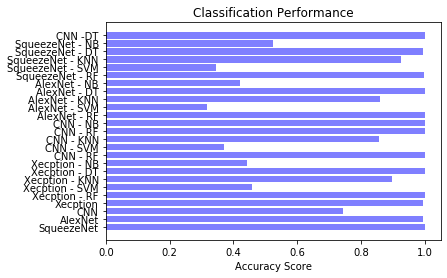

In [251]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

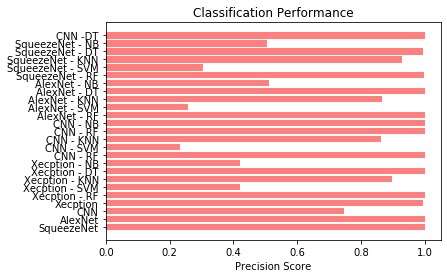

In [252]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

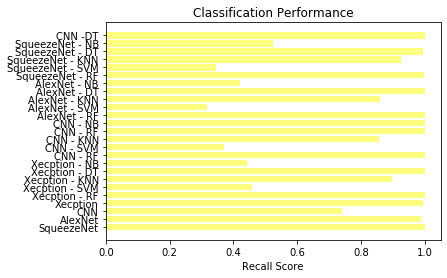

In [253]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

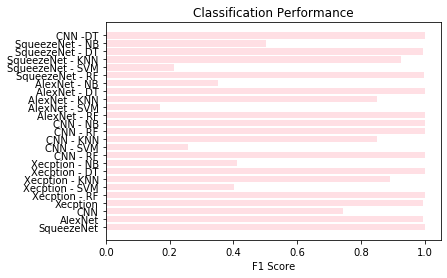

In [255]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

In [45]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()